In [1]:
import numpy as np
from scipy import signal
import scipy.spatial.distance as distfuncs
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path

import sys
sys.path.append('../')
import irutilities as irutil
import sf_func as sf

In [2]:
# Load ir data
sessionName = "S32-M441_npy"
sessionPath = Path('..').joinpath(sessionName)
posAll, posSrc, irAll = irutil.loadIR(sessionPath)

numAll = posAll.shape[0]
numSrc = posSrc.shape[0]

posAllX = np.unique(posAll[:,0].round(4))
posAllY = np.unique(posAll[:,1].round(4))
numAllXY = (posAllX.shape[0], posAllY.shape[0])

# Sampling rate (original)
samplerate_raw = 48000

In [3]:
# Downsampling
downSampling = 6
irAll = signal.resample_poly(irAll, up=1, down=downSampling, axis=-1)
samplerate = samplerate_raw // downSampling
print('samplerate (Hz): ', samplerate)

posAllXY, _, idxAllXY = irutil.sortIR(posAll[:,0:2], irAll, numAllXY, posAllX, posAllY)

# Truncation of IRs
irLen = 4096
irAll = np.transpose(irAll, (2,1,0))
irAll = irAll[0:irLen,:,:]
print('ir length:', irLen)

samplerate (Hz):  8000
ir length: 4096


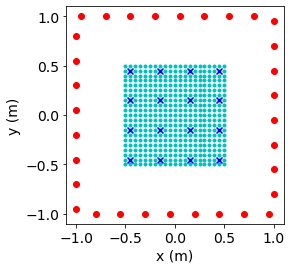

In [4]:
# Target region and evaluation points
dimsEval = [1.0, 1.0]
idxEval = np.where( (np.abs(posAll[:,0])<=dimsEval[0]/2) & (np.abs(posAll[:,1])<=dimsEval[1]/2) )[0]
posEval = posAll[idxEval,:]
numEval = posEval.shape[0]
posEvalX = np.unique(posEval[:,0].round(4))
posEvalY = np.unique(posEval[:,1].round(4))
irEval = irAll[:,idxEval,:]

# Control points
xGrid = np.arange(-dimsEval[0]/2+0.05, dimsEval[0]/2, 0.3)
yGrid = np.arange(-dimsEval[1]/2+0.05, dimsEval[1]/2, 0.3)

xIdx = []
for ii in np.arange(xGrid.shape[0]):
    xIdx.append(np.where( np.isclose(posEval[:,0], xGrid[ii]) ))
yIdx = []
for ii in np.arange(yGrid.shape[0]):
    yIdx.append(np.where( np.isclose(posEval[:,1], yGrid[ii]) ))

idxMic = np.intersect1d(xIdx, yIdx)
numMic = idxMic.shape[0]
posMic = posAll[idxMic,:]

# IR at control points
irMic = irAll[:,idxMic,:]

# Plot geometry
plt.rcParams["font.size"] = 14

fig, ax = plt.subplots()
ax.scatter(posEval[:,0], posEval[:,1], marker='.', color='c')
ax.scatter(posMic[:,0], posMic[:,1], marker='x', color='b')
ax.scatter(posSrc[:,0], posSrc[:,1], marker='o', color='r')
ax.set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


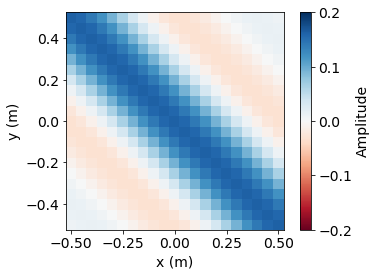

In [5]:
# FFT parameters
fftlen = 16384
freq = np.arange(1,int(fftlen/2)+1)/fftlen*samplerate  # Frequency
numFreq = freq.shape[0]  # Number of frequency bins
c = 341.9  # Sound speed
k = 2.0 * np.pi * freq / c  # Wavenumber

# Filter parameters
smplShift = 4096
filterLen = 8192

# Lowpass filter
maxFreq = 700
h = signal.firwin(numtaps=64, cutoff=maxFreq, fs=samplerate)

# Desired sound field
pwAng = (np.pi/4, np.pi/2)
des = sf.planewave(1.0, pwAng[0], pwAng[1], posMic[:,0].T, posMic[:,1].T, posMic[:,2].T, k[:,None])

synTrueAll_f = sf.planewave(1.0, pwAng[0], pwAng[1], posAll[:,0].T, posAll[:,1].T, posAll[:,2].T, k[:,None])
synTrueAll_f = np.concatenate( (np.zeros((1,numAll)), synTrueAll_f, synTrueAll_f[int(fftlen/2)-2::-1,:].conj()) )
synTrueAll = np.fft.ifft(synTrueAll_f, n=fftlen, axis=0).real
synTrueAll = np.concatenate((synTrueAll[fftlen-smplShift:fftlen,:], synTrueAll[:fftlen-smplShift,:]))
synTrueAll = signal.filtfilt(h, 1, synTrueAll, axis=0)

synTrue = synTrueAll[:,idxEval]
distTrue = synTrueAll[:,idxAllXY]

# Draw pressure distribution
tIdx = smplShift

xx, yy = np.meshgrid(posEvalX, posEvalY)

fig, ax = plt.subplots()
ax = plt.axes()
color = plt.pcolormesh(xx, yy, distTrue[tIdx,:,:].T, cmap='RdBu', shading='auto', vmin=-0.2, vmax=0.2)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.savefig("control_true.pdf")
plt.show()


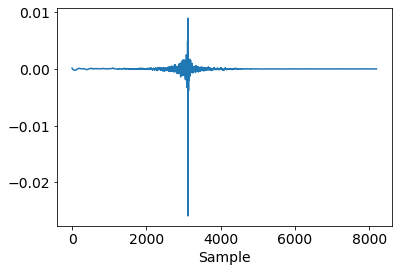

In [6]:
# Transfer function matrix
tfMic = np.fft.fft(irMic, n=fftlen, axis=0)
G = tfMic[1:int(fftlen/2)+1,:,:]  # Transfer functions of positive frequencies

# Regularization parameter
reg = 1e+2

# Pressure matching
drvPM = np.squeeze( np.linalg.inv(np.transpose(G.conj(), (0,2,1)) @ G + reg * np.eye(numSrc)) @ np.transpose(G.conj(), (0,2,1)) @ des[:,:,None] )
drvPM = np.concatenate( (np.zeros((1,numSrc)), drvPM, drvPM[int(fftlen/2)-2::-1,:].conj()) )

filterPM = np.fft.ifft(drvPM, n=fftlen, axis=0).real
filterPM = np.concatenate((filterPM[fftlen-smplShift:fftlen,:], filterPM[:filterLen-smplShift,:]))

# Plot filter
fig, ax = plt.subplots()
ax.plot(filterPM[:,0])
plt.xlabel('Sample')
plt.show()


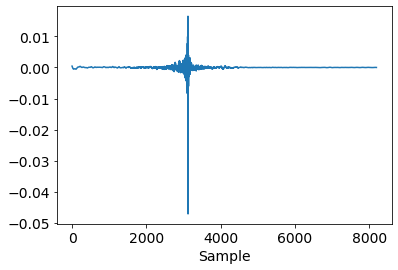

In [10]:
# Estimation of spherical wavefunction expansion coefficients of loudspeaker transfer functions
posEst = np.zeros((1,3))  # Origin
orderMic = 0  # Pressure microphone
orderEst = 12  # Maximum order for estimation
coefMic = np.ones((1, numMic), dtype=complex)  # Expansion coefficients of microphone directivity

# Load estimation operator
fileName = 'coefEstOp_o%d_m%d_f%d.npy' % (orderEst, numMic, numFreq)
filePath = Path('__file__').parent.joinpath(fileName)
coefEstOpr = np.load(filePath)
# To generate (and save) a new estimation operator, uncomment the following lines 
# coefEstOpr = sf.coefEstOprGen(posEst, orderEst, posMic, orderMic, coefMic, k)
# np.save(filePath, coefEstOpr)

# Estimation of expantion coefficients of loudspeaker transfer functions
GMode = np.zeros((k.shape[0], (orderEst+1)**2, numSrc), dtype=complex)
for ss in np.arange(numSrc):
    sigG = G[:, :, ss]
    GMode[:, :, ss] = np.squeeze( coefEstOpr @ sigG[:, :, None] )

# Expansion coefficients of desired sound field
desMode = sf.planewave_mode(orderEst, 1.0, pwAng[0], pwAng[1], 0., 0., 0., k[None,:]).T

# Weighting matrix for weighted mode-matching
fileName = 'WeightMode_o%d_xyplane_f%d.npy' % (orderEst, numFreq)
filePath = Path('__file__').parent.joinpath(fileName)
WMode = np.load(filePath)
# To generate (and save) a new weighting matrix for weighted mode-matching, uncomment the following lines
# mcNumPoints = 1000
# WMode = sf.weightWMM(k, orderEst, mcNumPoints, dimsEval)
# np.save(filePath, WMode)

# Regularization parameter
reg = 1e+0

# Weighted mode-matching
drvWMM = np.squeeze( np.linalg.inv(np.transpose(GMode.conj(), (0,2,1)) @ WMode @ GMode + reg * np.eye(numSrc)) @ np.transpose(GMode.conj(), (0,2,1)) @ WMode @ desMode[:,:,None] )
drvWMM = np.concatenate( (np.zeros((1,numSrc)), drvWMM, drvWMM[int(fftlen/2)-2::-1,:].conj()) )

filterWMM = np.fft.ifft(drvWMM, n=fftlen, axis=0).real
filterWMM = np.concatenate((filterWMM[fftlen-smplShift:fftlen,:], filterWMM[:filterLen-smplShift,:]))

# Plot filter
fig, ax = plt.subplots()
ax.plot(filterWMM[:,0])
plt.xlabel('Sample')
plt.show()


[SDR] PM: 3.896651, WMM: 4.695154


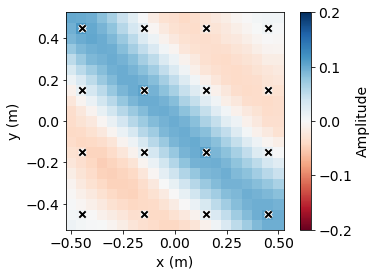

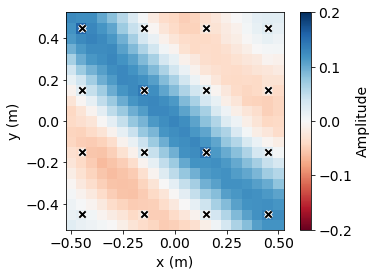

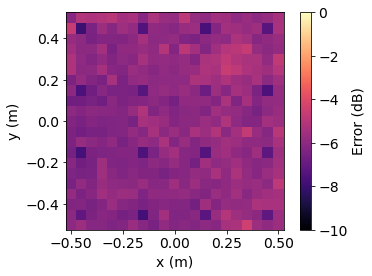

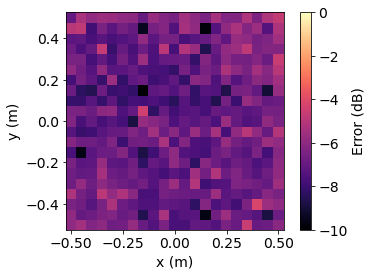

In [11]:
# Lowpass
sigPM = signal.filtfilt(h, 1, filterPM, axis=0)
sigWMM = signal.filtfilt(h, 1, filterWMM, axis=0)

# Convolution of filters
tfAll = np.fft.fft(irAll, n=fftlen, axis=0)

sigPM_f = np.fft.fft(sigPM, n=fftlen, axis=0)
synPM_All = np.fft.ifft(tfAll @ sigPM_f[:,:,None], n=fftlen, axis=0).real
synPM = np.squeeze(synPM_All[:,idxEval])
distPM = np.squeeze(synPM_All[:,idxAllXY])
errPM = np.sum( np.abs(distPM - distTrue) ** 2, axis=0) / np.sum( np.abs(distTrue) ** 2, axis=0)
SDR_PM = np.sum( np.sum( np.abs(synTrue) ** 2) ) / np.sum( np.sum( np.abs(synPM - synTrue) ** 2) ) 

sigWMM_f = np.fft.fft(sigWMM, n=fftlen, axis=0)
synWMM_All = np.fft.ifft(tfAll @ sigWMM_f[:,:,None], n=fftlen, axis=0).real
synWMM = np.squeeze(synWMM_All[:,idxEval])
distWMM = np.squeeze(synWMM_All[:,idxAllXY])
errWMM = np.sum( np.abs(distWMM - distTrue) ** 2, axis=0) / np.sum( np.abs(distTrue) ** 2, axis=0)
SDR_WMM = np.sum( np.sum( np.abs(synTrue) ** 2) ) / np.sum( np.sum( np.abs(synWMM - synTrue) ** 2) )

# Signal-to-distortion ration (SDR)
print('[SDR] PM: %f, WMM: %f' % (SDR_PM, SDR_WMM))

# Draw pressure distribution
fig, ax = plt.subplots()
ax = plt.axes()
color = plt.pcolormesh(xx, yy, distPM[tIdx,:,:].T, cmap='RdBu', shading='auto', vmin=-0.2, vmax=0.2)
ax.scatter(posMic[:,0], posMic[:,1], marker='x', s=40, linewidths=4, color='w')
ax.scatter(posMic[:,0], posMic[:,1], marker='x', s=40, linewidths=2, color='k')
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.savefig("control_syn_pm.pdf")

fig, ax = plt.subplots()
ax = plt.axes()
color = plt.pcolormesh(xx, yy, distWMM[tIdx,:,:].T, cmap='RdBu', shading='auto', vmin=-0.2, vmax=0.2)
ax.scatter(posMic[:,0], posMic[:,1], marker='x', s=40, linewidths=4, color='w')
ax.scatter(posMic[:,0], posMic[:,1], marker='x', s=40, linewidths=2, color='k')
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

# Draw error distribution
fig, ax = plt.subplots()
ax = plt.axes()
color = plt.pcolormesh(xx, yy, 10 * np.log10(errPM.T), cmap='magma', shading='auto', vmin=-10.0, vmax=0.0)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Error (dB)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.savefig("control_error_pm.pdf")

fig, ax = plt.subplots()
ax = plt.axes()
color = plt.pcolormesh(xx, yy, 10 * np.log10(errWMM.T), cmap='magma', shading='auto', vmin=-10.0, vmax=0.0)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Error (dB)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()